# Forecasting model for FSLR (First Solar) and ENPH (Enphase Energy)


---



#  Import Libraries and Connect to the Database

In [2]:
!pip install keras

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

Connecting to the SQLite database

In [4]:
db_path = 'financial_data.db'
conn = sqlite3.connect(db_path)

Fetching data for FSLR and ENPH

In [6]:
query = """
    SELECT Date, Asset AS Company, Close
    FROM solar_data
    WHERE Asset IN ('FSLR', 'ENPH')
"""
data = pd.read_sql(query, conn)
data['Date'] = pd.to_datetime(data['Date'])

# Close the connection
conn.close()

# Data Preprocessing

In [7]:
# Handle duplicate dates
data = data.groupby(['Date', 'Company']).mean().reset_index()

# Pivot data to create separate columns for FSLR and ENPH
pivot_data = data.pivot(index='Date', columns='Company', values='Close')
pivot_data = pivot_data.asfreq('B')  # Ensure business day frequency

# Fill missing values
pivot_data = pivot_data.ffill().bfill()


# LSTM Function

In [8]:
def train_lstm(series, company_name, seq_length=30, future_steps=30, epochs=50, batch_size=32):
    print(f"\nProcessing {company_name}...\n")

    # Handle NaN values
    series = series.ffill().bfill()

    # Step 1: Scale the data
    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series.values.reshape(-1, 1))

    # Step 2: Create sequences for LSTM
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length])
            y.append(data[i + seq_length])
        return np.array(X), np.array(y)

    X, y = create_sequences(series_scaled, seq_length)

    # Step 3: Split data into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Step 4: Build the LSTM model with custom Adam optimizer
    from keras.optimizers import Adam
    optimizer = Adam(learning_rate=0.001)  # Custom learning rate

    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mse')  # Use custom Adam optimizer

    # Step 5: Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

    # Step 6: Make predictions
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Step 7: Evaluate the model
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mse)

    print(f"Metrics for {company_name}:")
    print(f"  Mean Squared Error (MSE): {mse}")
    print(f"  Mean Absolute Error (MAE): {mae}")
    print(f"  Root Mean Squared Error (RMSE): {rmse}")

    # Step 8: Plot actual vs forecast
    plt.figure(figsize=(12, 6))
    plt.plot(series.index[-len(y_test):], y_test_rescaled, label="Actual", color='blue')
    plt.plot(series.index[-len(y_test):], y_pred_rescaled, label="Forecast", color='red')
    plt.title(f"LSTM Forecast for {company_name}")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Step 9: Forecast future values
    def forecast_future(data, model, steps, seq_length):
        forecasted = []
        input_seq = data[-seq_length:]  # Start with the last available data

        for _ in range(steps):
            prediction = model.predict(input_seq.reshape(1, seq_length, 1))
            forecasted.append(prediction[0, 0])
            input_seq = np.append(input_seq[1:], prediction)  # Update sequence with the predicted value

        return np.array(forecasted)

    future_forecast = forecast_future(series_scaled, model, future_steps, seq_length)
    future_forecast_rescaled = scaler.inverse_transform(future_forecast.reshape(-1, 1))

    # Plot future forecast
    future_dates = pd.date_range(start=series.index[-1], periods=future_steps + 1, freq='B')[1:]
    plt.figure(figsize=(12, 6))
    plt.plot(series, label="Original Data")
    plt.plot(future_dates, future_forecast_rescaled, label="Future Forecast", color='green')
    plt.title(f"LSTM Future Forecast for {company_name}")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()



Processing FSLR...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.0115 - val_loss: 0.0156
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 9.7580e-04 - val_loss: 0.0042
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 8.9068e-04 - val_loss: 0.0047
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 7.0279e-04 - val_loss: 0.0043
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 6.3768e-04 - val_loss: 0.0033
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 6.3270e-04 - val_loss: 0.0025
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 5.0290e-04 - val_loss: 0.0026
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 6.3890e-04 - val_loss: 0.0022
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 4.8262e-04 - val_loss: 0.0022
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 6.2472e-04 - val_loss: 0.0023
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 5.4009e-04 - val_loss: 0.0028
Epoch 12/50
63/63 ━━━━━

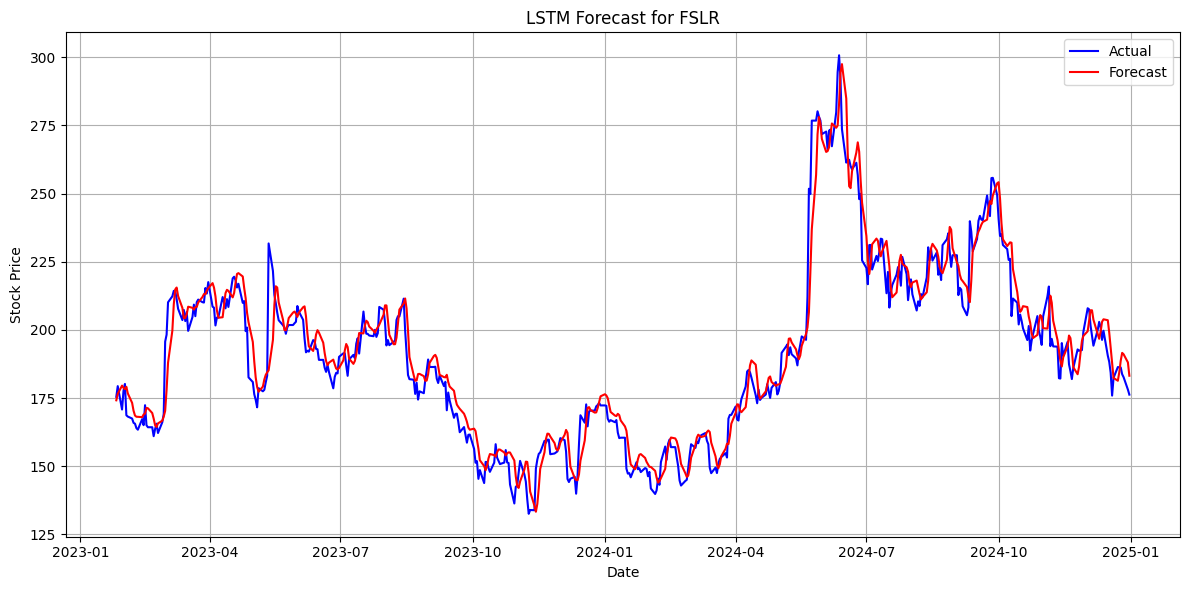

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

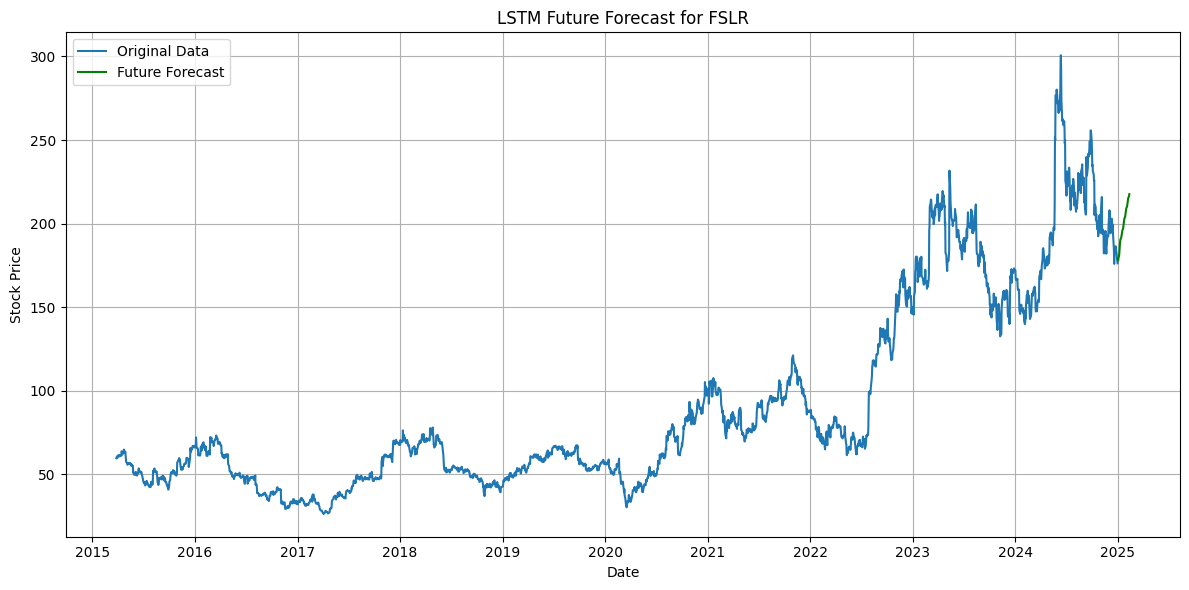


Processing ENPH...

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0507 - val_loss: 0.0019
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0026 - val_l

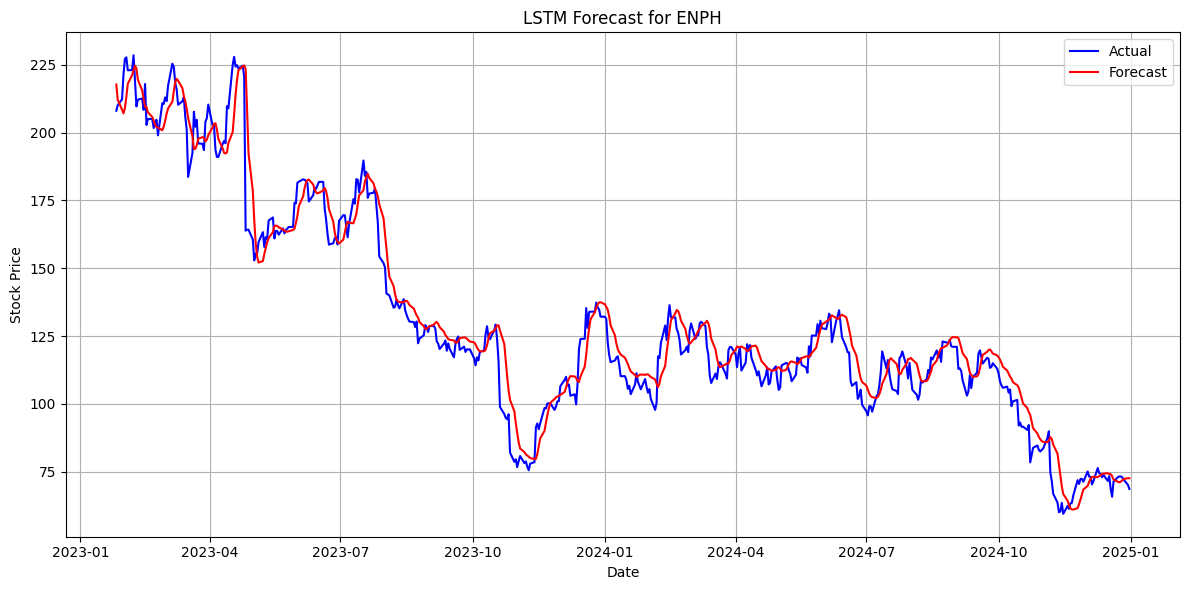

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

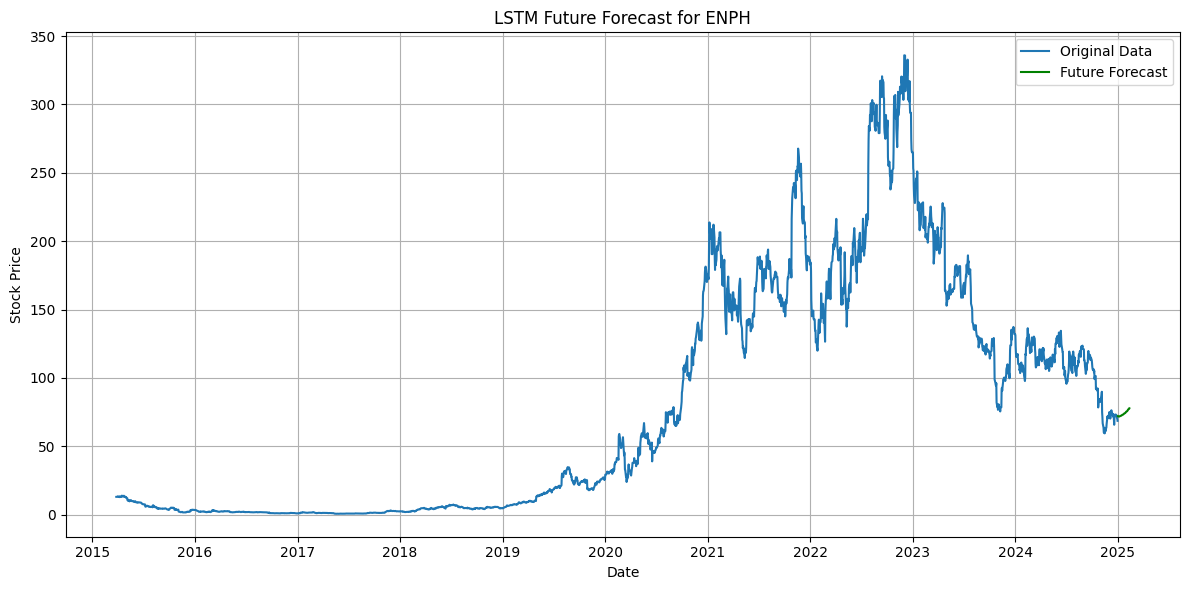

In [9]:
for company in ['FSLR', 'ENPH']:
    train_lstm(pivot_data[company], company_name=company)


# Interpretation of the Results

Interpretation of the Results: Comparison Between FSLR and ENPH
Both FSLR and ENPH's LSTM forecasts provide valuable insights into their future performance based on historical trends. Here’s a detailed interpretation of the results:

1. FSLR Forecast (First Plot):
Historical Performance:
FSLR exhibits steady growth with occasional fluctuations. Significant peaks were observed between 2021 and 2023, indicating increased volatility in this period.
Future Forecast:
The green line suggests a moderate upward trend for the next 30 business days, implying a recovery or stable growth after a recent dip.
The forecast aligns well with recent trends, suggesting that the model has captured the key dynamics of the stock.
2. ENPH Forecast (Second Plot):
Historical Performance:
ENPH shows rapid growth from 2020 to 2022, followed by a sharp decline in 2023. This behavior indicates high volatility and possibly greater sensitivity to external factors (e.g., market or regulatory changes).
Future Forecast:
The green line suggests a slight upward movement, hinting at a recovery from its recent downward trend. However, the magnitude of recovery is less pronounced compared to FSLR.
3. Comparison Between FSLR and ENPH:
Volatility:
ENPH appears to be more volatile than FSLR, with larger peaks and sharper declines. FSLR shows a more stable trajectory overall.
Forecast Trend:
Both forecasts indicate an upward trend in the near future. However, FSLR’s forecast suggests more significant growth compared to ENPH.
Market Sentiment:
FSLR's historical stability and stronger recovery forecast could indicate greater investor confidence compared to ENPH.
4. Metrics for Evaluation:
If you’ve already computed performance metrics (e.g., MSE, MAE, RMSE), these can be used to compare model performance for each company. For example:

Lower RMSE indicates better accuracy.
Comparing metrics for FSLR and ENPH will highlight how well the model captures each company's dynamics.
5. Business Implications:
FSLR:
Investors might find FSLR more attractive due to its steady historical growth and stronger recovery outlook.
ENPH:
ENPH might appeal to risk-tolerant investors looking for opportunities in a highly volatile stock with potential for rapid gains.